# X-ray challenge

In [1]:
%cd ./drive/MyDrive/raw_data



/content/drive/MyDrive/raw_data


In [2]:
%ls


bacterial_pneumonia/  covid-19/  normal/  viral_pneumonia/


In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib.pyplot import imread
import pathlib

In [4]:
print(tf.__version__)

2.4.1


In [5]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

#data_dir = pathlib.Path(dataset_path)

In [7]:
os.listdir("/content/drive/MyDrive/raw_data")

['covid-19', 'normal', 'viral_pneumonia', 'bacterial_pneumonia']

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os

list = os.listdir("/content/drive/MyDrive/raw_data/covid-19") # dir is your directory path
number_files = len(list)
print (number_files)

1014


In [10]:
import os

list = os.listdir("/content/drive/MyDrive/raw_data/normal") # dir is your directory path
number_files = len(list)
print (number_files)

1443


In [11]:
import os

list = os.listdir("/content/drive/MyDrive/raw_data/viral_pneumonia") # dir is your directory path
number_files = len(list)
print (number_files)

1512


In [12]:
1512*0.2

302.40000000000003

In [13]:
import os

list = os.listdir("/content/drive/MyDrive/raw_data/bacterial_pneumonia") # dir is your directory path
number_files = len(list)
print (number_files)

2727


In [14]:
2727*0.2

545.4

In [15]:
labels = os.listdir("/content/drive/MyDrive/trainset ")

In [16]:
labels

['.DS_Store', 'viral_pneumonia', 'bacterial_pneumonia', 'covid-19', 'normal']

In [17]:
labels.remove('.DS_Store')

In [18]:
labels

['viral_pneumonia', 'bacterial_pneumonia', 'covid-19', 'normal']

In [19]:
type(os.listdir("/content/drive/MyDrive/trainset "))

list

In [20]:
os.listdir("/content/drive/MyDrive/trainset ")

['.DS_Store', 'viral_pneumonia', 'bacterial_pneumonia', 'covid-19', 'normal']

In [21]:
dataset_path = "/content/drive/MyDrive/trainset "

In [22]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 5316 files belonging to 4 classes.
Using 4253 files for training.


In [23]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=32)

Found 5316 files belonging to 4 classes.
Using 1063 files for validation.


In [25]:
val_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [26]:
class_names = train_ds.class_names
print(class_names)

['bacterial_pneumonia', 'covid-19', 'normal', 'viral_pneumonia']


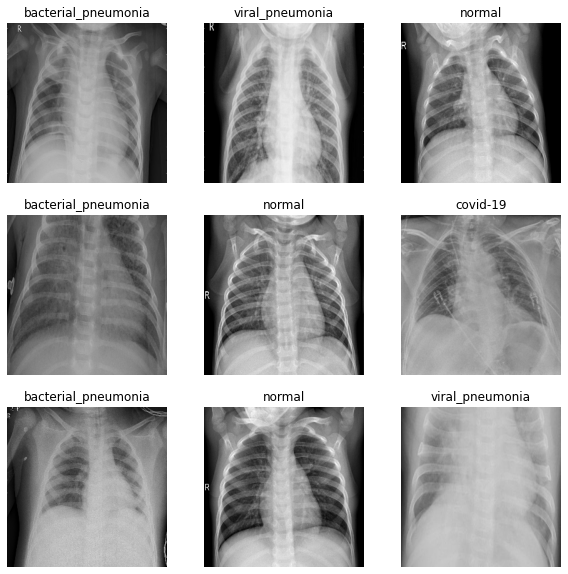

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [29]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [30]:
val_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [31]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [32]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.0 0.99855626


In [42]:
normalized_train_ds

<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [34]:
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch_val, labels_batch_val = next(iter(normalized_val_ds))
first_image_val = image_batch_val[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image_val), np.max(first_image_val)) 

0.0032571233 1.0


In [35]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
num_classes = 4

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(
  optimizer='adam',
  loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [38]:
from tensorflow.keras import callbacks

es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [39]:
model.fit(normalized_train_ds,
          batch_size=32,
          epochs=100,
          validation_data=normalized_val_ds,
          callbacks=[es])

Epoch 1/100
133/133 [==============================] - 1406s 11s/step - loss: 1.3361 - accuracy: 0.3821 - val_loss: 1.3516 - val_accuracy: 0.3857
Epoch 2/100
133/133 [==============================] - 53s 386ms/step - loss: 1.3240 - accuracy: 0.4065 - val_loss: 1.2088 - val_accuracy: 0.3913
Epoch 3/100
133/133 [==============================] - 53s 381ms/step - loss: 0.9286 - accuracy: 0.5908 - val_loss: 0.7467 - val_accuracy: 0.6660
Epoch 4/100
133/133 [==============================] - 53s 382ms/step - loss: 0.5966 - accuracy: 0.7506 - val_loss: 0.6013 - val_accuracy: 0.7526
Epoch 5/100
133/133 [==============================] - 52s 379ms/step - loss: 0.5614 - accuracy: 0.7583 - val_loss: 0.5981 - val_accuracy: 0.7535
Epoch 6/100
133/133 [==============================] - 53s 381ms/step - loss: 0.5294 - accuracy: 0.7673 - val_loss: 0.6026 - val_accuracy: 0.7422
Epoch 7/100
133/133 [==============================] - 53s 381ms/step - loss: 0.5091 - accuracy: 0.7792 - val_loss: 0.5717 -

In [46]:
from tensorflow.keras import models

# Let's say that you have a `model`
# You can save it :
models.save_model(model, '/content/drive/MyDrive/models/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/my_model/assets


In [41]:
# and you can load it somewhere else :
#loaded_model = models.load_model('my_model')